# Stabilizer current sense AFE noise/stability model

All values are referred to the coil current (RTC)

See *Merkel et al* in prep

In [6]:
import numpy as np
from scipy import constants
import matplotlib.pyplot as plt

def johnson(res, temp=300):
    """ Johnson Voltage noise density caluclator
    :param res: resistance (Ohm)
    :param temp: temperature (K)
    :return: RMS noise voltage density (V/rtHz)
    """
    return np.sqrt(4*constants.k*res*temp) 

In [7]:
# simulation parameters
I_coil = 137  # coil current (A)
field = 28.8e-3  # Magnetic field (Tesla)
loop_bw = 1e3  # feedback loop noise bandwidth (Hz)

G_coil = field/I_coil  # Coil gain (T/A)

In [8]:
# pick one of ..

# Sensor option I: LEM-IT-400-S Sensor
# data sheet: https://www.lem.com/sites/default/files/products_datasheets/it_400-s_ultrastab.pdf
# NB a newer model is now available: https://www.lem.com/sites/default/files/products_datasheets/in_1000-s.pdf

n_turns = 2  # number of turns of wire around the sensor
sensor_Ifs = 400  # sensor full-scale current (A)
G_sensor = 1/2000 * n_turns  # A/A
R_sense = 10  # transimpedance resistor in analog front-end (Ohm)

if (I_coil * n_turns) > sensor_Ifs:
    raise ValueError("Too much flux through the sensor")

# Broad-band noise:
# - We measured the sensor noise floor to be <~5ppb/rtHz (RMS of full-scale)
#   this measurement was limited by the noise floor of our analog front end
# - The sensor data sheet specifies 8ppm RMS MAX integrated over 50kHz
#   eqivalent to 35ppb/rtHz
# - so the specification appears to be rather cautious
# - The newer IN-1000-S model specifies both typical and max noise,
#   with a factor of three difference between the two
in_sensor = 5e-9*(sensor_Ifs/n_turns) # sensor current noise (A RTC)

# sensor low frequency noise:
# 0 to 10Hz integrated noise (pk-pk normalized to full-scale coil current)
# taken from datasheet, probably quite pessimistic
In_sensor = 0.05e-6*(sensor_Ifs/n_turns)/I_coil

print("power dissipated in sense resistor: {:.2f}W".format((I_coil*G_sensor)**2*R_sense))

power dissipated in sense resistor: 0.19W


In [ ]:
# or...

# Sensor option II: resistor
G_sensor = 1
R_sense = 1/2000*6*10  # chosen to give same output voltage as the flux-gate
in_sensor = 0  # no broard-band noise on top of the sense resistor Johnson noise
In_sensor = 0  # no low-frequency noise

print("power dissipated in {:.1f} mOhm sense resistor: {:.1f}W".format(R_sense*1e3, I_coil**2*R_sense))

## Broadband noise

- Our measurements indicate that the flux-gate sensor noise is far lower than the MAX specification on the data sheet. We weren't able to measure it accurately in the previous tests we performed. For now we assume that it can be neglected.
- With that assumption, the broadband noise is dominated by the 1k resistors we use in the InAmp and subtractor.
- So, to lower the circuit noise we would need to lower the value of these resistors. Johnson noise scales like the root of the resistance, so we'd really need to lower it by a factor of 5-10 to make this worthwhile. Note, however, that when using resistor ladders we don't have a huge amount of choice in the resistor values.
- If we lower the resistance to 100R then, assuming a 2V sensor voltage, the current through the resistors is 20mA. That's within the drive capability of many OpAmps, but still quite a bit.
- NB 100R puts the noise contribution from the resistors about equal to using OpAmps with 1nV/rtHz (which is about as low as one can get). So there isn't much point pushing it lower than this.
- The power dissipated in the resistor would be 40mW (160mW for a quad resistor package) which is OK.
- Potentially worse would be the power dissipated in the OpAmp. Assuming we keep the +-12V rails, this would be 240mW per OpAmp. Depending on the OpAmp and package layout, that could gi~ve quite a large temperature increase and impact stability.
- So, it looks like using 100R resistors and an OpAmp with 1nV/rtHz noise we can probably get the AFE broadband noise down by a factor of 2-3 at the cost of a significant increase in power dissipation. However, in practice, we may well not see that improvement since, for example, the sensor noise could start to dominate. Note also, that the low-frequency noise is harder to reduce without doing something daft like parallelling large numbers of voltage references.
- My current feeling is that it's not worth trying to squeeze out that last iota of performance, but the option is there if a user has an application where they do need it.

In [9]:
def print_white_noise(name, i_n):
    """:param i_n: noise density (A/rtHz)"""
    print("{}: {:.2f} uA/rtHz ({:.2f} nT/rtHz), {:.2f} uA RMS ({:.2f} nT RMS)".format(
        name,
        i_n*1e6,
        i_n*G_coil*1e9,
        i_n*np.sqrt(loop_bw)*1e6,
        i_n*np.sqrt(loop_bw)*G_coil*1e9))

In [10]:
# transimpedance stage
G_sense = G_sensor*R_sense  # V/A RTC

vn_sense = johnson(R_sense)
in_sense = vn_sense/G_sense  # A/rtHz RTC

print_white_noise("sense resistor", in_sense)

sense resistor: 0.04 uA/rtHz (0.01 nT/rtHz), 1.29 uA RMS (0.27 nT RMS)


In [87]:
# InAmp
# NB stage bandwidth is large compared with loop BW so assume white noise

# ADA4004 (used in previous version of the design)
# opamp_vn = 1.8e-9  # voltage noise density (V/rtHz)
# opamp_in = 1.2e-12  # current noise density (A/rtHz)

# LT1007
opamp_vn = 2.5e-9  # voltage noise density (V/rtHz)
opamp_in = 400e-15  # current noise density (A/rtHz)

R_in = 16  # RFI filter resistors
R_inamp = 1e3  # InAmp resistors

noise_sources = [
    johnson(R_in)*np.sqrt(2),
    johnson(R_inamp)*np.sqrt(4),
    opamp_vn*np.sqrt(1**2 + 1**2 + 2**2),  # noise gain of final OpAmp is 2
    opamp_in*R_inamp*np.sqrt(2)
]

vn_inamp = np.sqrt(sum([noise**2 for noise in noise_sources]))
in_inamp = vn_inamp/G_sense

print_white_noise("InAmp resistors", noise_sources[1]/G_sense)
print_white_noise("InAmp OpAmp vn", noise_sources[2]/G_sense)
print_white_noise("InAmp OpAmp in", noise_sources[3]/G_sense)
print_white_noise("InAmp total", in_inamp)

InAmp resistors: 0.81 uA/rtHz (0.17 nT/rtHz), 25.74 uA RMS (5.41 nT RMS)
InAmp OpAmp vn: 0.61 uA/rtHz (0.13 nT/rtHz), 19.36 uA RMS (4.07 nT RMS)
InAmp OpAmp in: 0.06 uA/rtHz (0.01 nT/rtHz), 1.79 uA RMS (0.38 nT RMS)
InAmp total: 1.02 uA/rtHz (0.22 nT/rtHz), 32.35 uA RMS (6.80 nT RMS)


In [88]:
# error subtractor
R_fb = 100e3
R_g = 1e3
G_subtractor = 1 + R_fb/R_g

# all numbers referred to subtractor input
vn_r_g = johnson(R_g)*(R_fb/R_g)/G_subtractor
vn_r_fb = johnson(R_fb)/G_subtractor
vn_res = np.sqrt(vn_r_g**2+vn_r_fb**2)

vn_opamp_in = opamp_in*R_fb/G_subtractor
vn_opamp = np.sqrt(opamp_vn**2 + vn_opamp_in**2)

vn_ref = opamp_vn*(R_fb/R_g)/G_subtractor  # only OpAmp vn as all else filtered!

vn_sub = np.sqrt(vn_res**2 + vn_opamp**2 + vn_ref**2)

in_sub = vn_sub/G_sense

print_white_noise("Subtractor resistors", vn_res/G_sense)
print_white_noise("Subtractor OpAmp vn", opamp_vn/G_sense)
print_white_noise("Subtractor OpAmp in", vn_opamp_in/G_sense)
print_white_noise("Subtractor reference", vn_ref/G_sense)
print_white_noise("Subtractor total", in_sub)

Subtractor resistors: 0.41 uA/rtHz (0.09 nT/rtHz), 12.81 uA RMS (2.69 nT RMS)
Subtractor OpAmp vn: 0.25 uA/rtHz (0.05 nT/rtHz), 7.91 uA RMS (1.66 nT RMS)
Subtractor OpAmp in: 0.04 uA/rtHz (0.01 nT/rtHz), 1.25 uA RMS (0.26 nT RMS)
Subtractor reference: 0.25 uA/rtHz (0.05 nT/rtHz), 7.83 uA RMS (1.65 nT RMS)
Subtractor total: 0.54 uA/rtHz (0.11 nT/rtHz), 17.01 uA RMS (3.58 nT RMS)


Total: 1.53 uA/rtHz (0.32 nT/rtHz), 48.33 uA RMS (10.16 nT RMS)


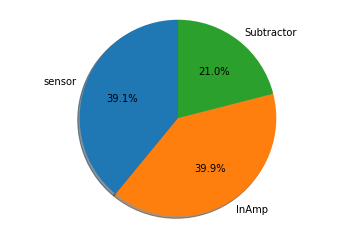

In [89]:
in_t = np.sqrt(in_sub**2 + in_inamp**2 + in_sensor**2)

labels = 'sensor', 'InAmp', 'Subtractor'
sizes = np.array([in_sensor, in_inamp, in_sub])
sizes /= sum(sizes)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

print_white_noise("Total", in_t)

## Low-frequency noise

Dominated by the DAC and voltage reference

In [90]:
def print_low_freq_noise(name, I_n):
    """:param I_n: peak-peak current noise as a fraction of the full-scale coil current"""
    print("{}: {:.2f} ppm pk-pk ({:.2f} nT pk-pk)".format(
        name,
        I_n*1e6,
        I_n*field*1e9))

In [91]:
# sensor noise
print_low_freq_noise("sensor", In_sensor)

sensor: 0.07 ppm pk-pk (2.10 nT pk-pk)


In [92]:
# reference LTC6655
# NB there is a newer -LN part number with lower noise
# the reference is filtered with a pole at ~16Hz, so we don't need to worry about the integrated white noise
V_ref = 2.5
i_dac_fs = V_ref/G_sense  # equivalent full-scale coil current
G_dac = (I_coil/i_dac_fs)  # conversion between DAC full-scale value and the coil current

Vn_ref = 0.25e-6  # 0..10Hz integrated noise (pk-pk as a fraction of full-scale)
In_ref = Vn_ref*G_dac  # pk-pk noise as a fraction of coil current after scaling by dac

print_low_freq_noise("reference", In_ref)

reference: 0.14 ppm pk-pk (3.95 nT pk-pk)


In [93]:
# DAC (AD5541)
# ignore DAC white noise density as small compared with the reference (and is filtered out anyway)

Vn_dac = 0.134e-6  # 0..10Hz pk-pk DAC noise (V)
In_dac = (Vn_dac/V_ref)*(i_dac_fs/I_coil)  # pk-pk as a fraction of the coil current

print_low_freq_noise("dac", In_dac)

dac: 0.10 ppm pk-pk (2.82 nT pk-pk)


In [94]:
# OpAmps

# ADA4004-4 voltage noise is 0.1uV pk-pk 0..10Hz
# vn_opamp = 0.15e-6  # 0..10Hz pk-pk DAC noise (V)
# in_opamp = (vn_opamp/G_sense)/I_coil  # pk-pk as a fraction of the coil current

# LT1007 voltage noise is 0.1uV pk-pk 0..10Hz
Vn_opamp = 60e-9  # 0..10Hz pk-pk DAC noise (V)
In_opamp = (Vn_opamp/G_sense)/I_coil  # pk-pk as a fraction of the coil current
In_opamp_T = In_opamp*np.sqrt(1**2 + 1**2 + 2**2)  # contribution from all OpAmops (noise gain of final InAmp OpAmp is 2)

print_low_freq_noise("OpAmp voltage noise", In_opamp_T)
# NB this is the noise for each OpAmp, so the total contribution will be several times this...

# ADA4004-4 low-frequency current noise is not well specified
# ballpark as follows:
# - current noise converted to voltage by resistors, which are all ~1k
# - typical bias current is 40nA, so gives offsets around 40uV
# - assume 0.1% stability for this (should be less thank that in a well temp controlled environment)
# - gives around 40nV fluctuations, which are small comapred with other contributions
# - so let's ignore this

# LT1007 current noise is still only 1.5pA/rtHz at 10Hz so we can ignore this safely!

OpAmp voltage noise: 0.11 ppm pk-pk (3.09 nT pk-pk)


Total : 0.21 ppm pk-pk (6.12 nT pk-pk)


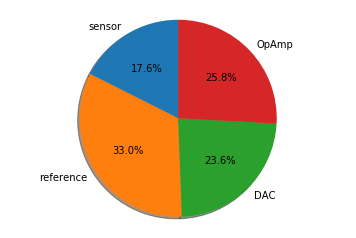

In [83]:
In_t = np.sqrt(In_sensor**2 + In_ref**2 + In_dac**2 + In_opamp_T**2)

labels = 'sensor', 'reference', 'DAC', 'OpAmp'
sizes = np.array([In_sensor, In_ref, In_dac, In_opamp_T])
sizes /= sum(sizes)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

print_low_freq_noise("Total ", In_t)

# Long-term/Thermal stability

## DAC
- offset (zero-code) temp co is: +-0.05 ppm/C
- gain temp co is +-0.1 ppm/C
- negligible

## OpAmps
- Offset voltage: 0.3uV/C typical, assuming 2V as the sensor volage, this corresponds to approx 0.15ppm/C
- offset/bias current: 20nA typical, corresponding to 20uV total offsets.
  Assuming this is stable to even 1%/C, it's negligible

## sense resistor
- ± 0.05 ppm/°C
- negligible

## InAmp resistors:
- LT5400-A-4 0.2ppm/C
- negligible

## fluxgate sensor:
- 1 ppm/K (MAX, probably pessimistic)

## reference:
- 20ppm/rt(k Hour)
- 1ppm/C typical assuming B-grade (else 2.5ppm/C)

## subtractor resistors:
 - no temp co specified. Assume these are 5ppm/K
 - $V_0 = V_{\mathrm{sensor}} + \frac{R_{\mathrm{f}}}{R_{\mathrm{g}}}\left(V_{\mathrm{ref}}-V_{\mathrm{sensor}}\right) $ 
 - for closed-loop operation, $V_0=0$ so $V_{\mathrm{sensor}}\left(1- \frac{R_{\mathrm{g}}}{R_{\mathrm{f}}}\right)= V_{\mathrm{ref}}$
 - so, all temperature coefficients are suppressed by a factor of order $\frac{R_{\mathrm{f}}}{R_{\mathrm{g}}} = 100 $
 - so, we do want something better than standard 100ppm/K, but don't need to be ultra-low temp co. (25ppm/K or lower is fine)
 - essentially, this is non-critical since the gain for the sensor and reference is almost identical, so drifts in the resistor values common-mode out

# Digital control loop

In one experiment we measured the power supply noise to be ~1mA. This is very dependent on the PSU and coil inductance, but it gives a ball-park to aim for in terms of dynamic range.

In [27]:
# Feedback ADC

G_error_amp = 1 + 20e3/1e3
G_AFE = G_sense*G_subtractor*G_error_amp # Volts per amp of coil current measured after the error amplifier
G_InAmp = 10**1  # InAmp gain
G_T = G_AFE*G_InAmp  # Total gain (V/A) at the ADC input
ADC_res = 20/(2**16)  # ADC resolution (V)

print("Total circuit gain: {:.1f} V/A ({:.1f} V/uT)".format(G_T, G_T/G_coil*1e-6))
print("1 LSB at the ADC is: {:.1f} uA ({:.2f} nT)".format(ADC_res/G_T*1e6, 1e9*ADC_res/G_T*G_coil))
print("ADC dynamic range is: {:.1f} mA ({:.1f} uT)".format(20./G_T*1e3, 1e6*20./G_T*G_coil))

Total circuit gain: 212.1 V/A (1.0 V/uT)
1 LSB at the ADC is: 1.4 uA (0.30 nT)
ADC dynamic range is: 94.3 mA (19.8 uT)


In [28]:
# Feedback Iset DAC
DAC_res = 20/2**16  # 1 DAC LSB in V
G_shunt = 1e-3 # gain of current shunt (A/V)

print("1 LSB at the DAC is: {:.1f} nA ({:.2f} nT)".format(DAC_res*G_shunt*1e9, DAC_res*G_shunt*G_coil*1e9))
print("DAC dynamic range is: {:.1f} mA ({:.2f} uT)".format(20.*G_shunt*1e3, 20.*G_shunt*G_coil*1e6))

1 LSB at the DAC is: 305.2 nA (0.06 nT)
DAC dynamic range is: 20.0 mA (4.20 uT)
